# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

# Downloading the Tanzania Waterpump Dataset

<font color=green> Make sure  you only use the dataset that is available through the **DS33** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.**DO NOT USE THE GITHUB LINK given in the assignemnts.**

<font color=purple> There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. <font color=purple> You can download the dataset directly by accessing the challenge and the files through this URL (make sure you have joined the competition!)

> https://www.kaggle.com/t/75a529de05884eb8af9789c2b064333a

2. Use the Kaggle API as I have done using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c ds33-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in your Kaggle folder on your google drive.
!ls

kaggle.json	    sample_submission.csv  train_features.csv
new_submission.csv  test_features.csv	   train_labels.csv


In [ ]:
%%capture
!pip install category_encoders==2.*

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Permutation Importance
from sklearn.inspection import permutation_importance

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Wrangle Data

We'll go back to Tanzania Waterpumps for this lesson.

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, parse_dates=['date_recorded'], na_values=[-2e-08, 0]),
                         pd.read_csv(tv_path)).set_index('date_recorded')

    else:
        df = pd.read_csv(fm_path, parse_dates=['date_recorded']).set_index('date_recorded')

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                       'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()

    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns=duplicates)

    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df = df.drop(columns=unusable_variance)

    # Extract components from date_recorded, then drop the original column
    df['year_recorded'] = df.index.year
    df['month_recorded'] = df.index.month
    df['day_recorded'] = df.index.day

    # Engineer feature: how many years from construction_year to date_recorded
    df['pump_age'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['pump_age'].isnull()

    # return the wrangled dataframe
    return df

In [ ]:
fm_path = 'train_features.csv'
tv_path = 'train_labels.csv'
df = wrangle(fm_path, tv_path)

In [ ]:
# Split data into feature and target
target = 'status_group'
X,y = df.drop(columns = target), df[target]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [ ]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,pump_age,years_MISSING
date_recorded,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-07-27,NaN,Swedish,NaN,Sengerema Water Department,32.757280,-2.532955,Kwa Msumali,NaN,Lake Victoria,Igalagalilo Mashariki,Mwanza,19,5.0,Sengerema,Katunguru,NaN,True,VWC,None,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,soft,good,dry,shallow well,shallow well,groundwater,hand pump,hand pump,False,False,True,True,True,2011,7,27,NaN,True
2013-02-13,NaN,Tassaf I,1326.0,TASSAF,30.902357,-3.635665,Kumbanga Zahanati,NaN,Lake Tanganyika,Kabogi,Kigoma,16,1.0,Kibondo,Murungu,300.0,True,VWC,NaN,False,2004.0,gravity,gravity,gravity,vwc,user-group,unknown,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,False,False,False,False,False,2013,2,13,9.0,False
2013-01-19,NaN,Finw,339.0,ter,39.493110,-10.863318,Kwa Nayopa,NaN,Ruvuma / Southern Coast,Mbuyuni,Mtwara,9,4.0,Tandahimba,Lukokoda,1.0,True,Water Board,Borehole,True,1982.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,False,False,False,False,False,2013,1,19,31.0,False
2013-09-03,NaN,World Vision,1803.0,World Vision,36.799547,-3.172507,Amosi,NaN,Internal,Karafia,Arusha,2,7.0,Meru,Ngarenanyuki,120.0,True,VWC,Kisimiri gravity water supply,True,2007.0,gravity,gravity,gravity,wug,user-group,unknown,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,False,False,False,2013,9,3,6.0,False
2011-07-14,NaN,Oxfam,NaN,OXFAM,30.814661,-2.431693,Kwa Razaro,NaN,Lake Victoria,Nyakahanga,Kagera,18,30.0,Ngara,Rusumo,NaN,True,VWC,Kamatendeli spring source,False,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,False,False,True,True,True,2011,7,14,NaN,True


In [ ]:
# Baseline Metric
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.5425489938182296


# Build Model

In [ ]:
model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42,n_estimators=75) # learning_rate=0.1
)

model_gb.fit(X_train,y_train);

In [ ]:
# xgboost = gradient boosting + regularization
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimators=75, n_jobs=-1) # learning_rate=0.1
)

model_xgb.fit(X_train,y_train);

# Check Metrics

In [ ]:
print('Training Accuracy', model_gb.score(X_train, y_train))
print('Validation Accuracy', model_gb.score(X_val, y_val))

Training Accuracy 0.7537550966723662
Validation Accuracy 0.7429503367003367


In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.7457582533210575
Validation Accuracy 0.7376893939393939


# Tuning / Communication

- How can we determine or communicate which features are most important to our model when making predictions?

**Option 1:** Grab feature importances from our pipeline


Text(0, 0.5, 'Feature')

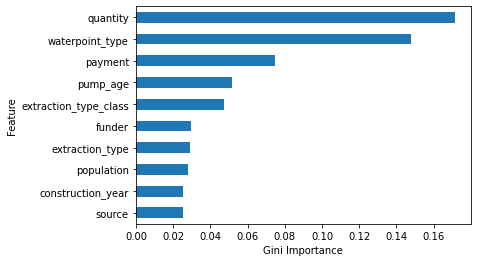

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

**Option 2:** Drop-column Importance

In [ ]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'longitude_MISSING', 'latitude_MISSING', 'construction_year_MISSING',
       'gps_height_MISSING', 'population_MISSING', 'year_recorded',
       'month_recorded', 'day_recorded', 'pump_age', 'years_MISSING'],
      dtype='object')

In [ ]:
col = 'quantity'

model_xgb_w_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimators=75, n_jobs=-1) # learning_rate=0.1
)

model_xgb_w_col.fit(X_train,y_train);

print(f'validation accuracy with "{col}"included:',model_xgb_w_col.score(X_val,y_val) )


validation accuracy with "quantity"included: 0.7376893939393939


In [ ]:
model_xgb_wo_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimators=75, n_jobs=-1) # learning_rate=0.1
)

model_xgb_wo_col.fit(X_train.drop(columns=col),y_train);

print(f'validation accuracy with "{col}"included:',model_xgb_wo_col.score(X_val.drop(columns=col),y_val) )

validation accuracy with "quantity"included: 0.7057028619528619


**Option 3:** Permutation Importance

In [ ]:


model_perm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42,n_estimators=75, n_jobs=-1) # learning_rate=0.1
)

model_perm.fit(X_train,y_train);


In [ ]:
print('validation accuracy', model_perm.score(X_val,y_val))

validation accuracy 0.7376893939393939


In [ ]:
col = 'source'

In [ ]:
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])

In [ ]:
print('validation accuracy', model_perm.score(X_val_perm,y_val))

validation accuracy 0.7363215488215489


In [ ]:
perm_imp = permutation_importance(model_perm, X_val, y_val, random_state=42)

In [ ]:
perm_imp

{'importances': array([[ 0.00010522,  0.00042088, -0.00021044,  0.00073653,  0.00042088],
        [ 0.0022096 ,  0.00378788,  0.00315657,  0.00494529,  0.00305135],
        [ 0.0016835 ,  0.00178872,  0.00431397,  0.00263047,  0.00105219],
        [ 0.00010522,  0.00010522,  0.00021044,  0.00021044,  0.00105219],
        [ 0.00431397,  0.00347222,  0.00199916,  0.00368266,  0.00347222],
        [ 0.00073653,  0.00136785,  0.00199916,  0.0016835 ,  0.00136785],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00084175,  0.00063131,  0.00063131,  0.00126263,  0.00105219],
        [ 0.        ,  0.00010522,  0.00010522,  0.00010522,  0.        ],
        [ 0.00294613,  0.00252525,  0.00178872,  0.00315657,  0.00294613],
        [ 0.00199916,  0.00210438,  0.00094697,  0.00178872,  0.00252525],
        [ 0.00063131,  0.00021044,  0.00178872,  0.00147306,  0.00073653],
        [ 

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

In [ ]:
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
extraction_type_group,-0.000737,0.000456
gps_height_MISSING,-0.000084,0.000079
construction_year_MISSING,-0.000042,0.000052
population_MISSING,0.000000,0.000000
latitude_MISSING,0.000000,0.000000
waterpoint_type_group,0.000000,0.000000
num_private,0.000000,0.000000
years_MISSING,0.000000,0.000000
wpt_name,0.000000,0.000000
subvillage,0.000063,0.000052


In [ ]:
Image(url= "https://i.imgur.com/h17tMUU.png")

#### Remove the less important features to train the model